In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

## Goal: Train RF and make predictions per each player

In [9]:
# Read in data
feature_set_2021 = pd.read_csv('../data/stats/past_seasons/combined_per60_roll15_2021.csv')
feature_set_2022 = pd.read_csv('../data/stats/past_seasons/combined_per60_roll15_2022.csv')
feature_set_2023 = pd.read_csv('../data/stats/past_seasons/combined_per60_roll15_2023.csv')

feature_set_all = pd.concat([feature_set_2021, feature_set_2022, feature_set_2023], axis=0).reset_index(drop = True)
#print(feature_set_all.info())
feature_set_all.head()

,s_player_id,s_name,s_age,season,s_game_num,date,s_team,s_opponent,s_home_away_status,s_result,...,g_age,g_game_num,decision,g_n_completed_games,GA_60,SA_60,SV_60,total_shutout,SV_perc,g_avg_TOI
0,/a/abramvi01,Vitaly Abramov,22,2021,1,2021-05-05,OTT,MTL,1,W,...,30,26,L,25,2.737591,27.786544,25.048953,0.0,0.901478,58.445556
1,/a/abramvi01,Vitaly Abramov,23,2021,2,2021-05-08,OTT,WPG,0,W,...,27,43,L,42,2.688031,30.004238,27.316207,2.0,0.910412,55.058889
2,/a/acciano01,Noel Acciari,29,2021,1,2021-01-17,FLA,CHI,1,W,...,26,2,L,1,5.000000,37.000000,32.000000,0.0,0.864865,60.000000
3,/a/acciano01,Noel Acciari,29,2021,2,2021-01-19,FLA,CHI,1,W,...,25,1,O,0,NaN,NaN,NaN,0.0,NaN,NaN
4,/a/acciano01,Noel Acciari,29,2021,3,2021-01-26,FLA,CBJ,0,W,...,26,4,O,3,2.338313,36.076830,33.738517,0.0,0.935185,59.872222


In [10]:
# First date that we began recording odds. This will be used to split the training and testing data
first_date = pd.read_csv('../data/odds/ml_odds.csv')['date_game'].min()
first_date

'2023-02-13'

In [16]:
# List of all x features in addition to target column
x_and_target = ['s_home_away_status', 'G_60', 'A_60', 'P_60', 'rating_60', 'PIM_60','EVG_60', 'PPG_60', 'SHG_60', 'GWG_60', 'EVA_60', 'PPA_60', 'SHA_60', 'S_60', 'shifts_60', 'HIT_60', 'BLK_60', 'FOW_60', 'FOL_60', 's_avg_TOI', 'GA_60', 'SA_60', 'SV_60', 'total_shutout', 'SV_perc', 'G']

In [17]:
# Split feature set into train and test
feature_set_for_preds = feature_set_all.loc[feature_set_all['date'] >= first_date, ['s_player_id', 's_name', 's_team', 'date', 's_result', 'G']]
train = feature_set_all.loc[feature_set_all['date'] < first_date, x_and_target].dropna()
test = feature_set_all.loc[feature_set_all['date'] >= first_date, x_and_target].dropna()

In [18]:
# Train using everything prior to the test set
x_train = train.drop(columns = ['G'])
x_test = test.drop(columns = ['G'])

y_train = train['G']
y_test = test['G']

# Find average goals per game that we can use to impute situations where no prediction was made about a player
avg_G_per_game = y_train.mean()
print(avg_G_per_game)

0.1701235550465394


### Try once with all features and look at feature importances

In [28]:
# Train RF using parameters from model exploration notebook
rf = RandomForestRegressor(max_depth=5, n_estimators=50)
rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=50)

[Text(0, 0, 'P_60'),
 Text(1, 0, 's_avg_TOI'),
 Text(2, 0, 'PPG_60'),
 Text(3, 0, 'S_60'),
 Text(4, 0, 'FOL_60'),
 Text(5, 0, 'G_60'),
 Text(6, 0, 'BLK_60'),
 Text(7, 0, 'shifts_60'),
 Text(8, 0, 'FOW_60'),
 Text(9, 0, 'SA_60'),
 Text(10, 0, 'GA_60'),
 Text(11, 0, 'PPA_60'),
 Text(12, 0, 'SV_60'),
 Text(13, 0, 'HIT_60'),
 Text(14, 0, 'EVA_60'),
 Text(15, 0, 'EVG_60'),
 Text(16, 0, 'rating_60'),
 Text(17, 0, 'PIM_60'),
 Text(18, 0, 'A_60'),
 Text(19, 0, 'SV_perc'),
 Text(20, 0, 'SHG_60'),
 Text(21, 0, 'GWG_60'),
 Text(22, 0, 'SHA_60'),
 Text(23, 0, 's_home_away_status'),
 Text(24, 0, 'total_shutout')]

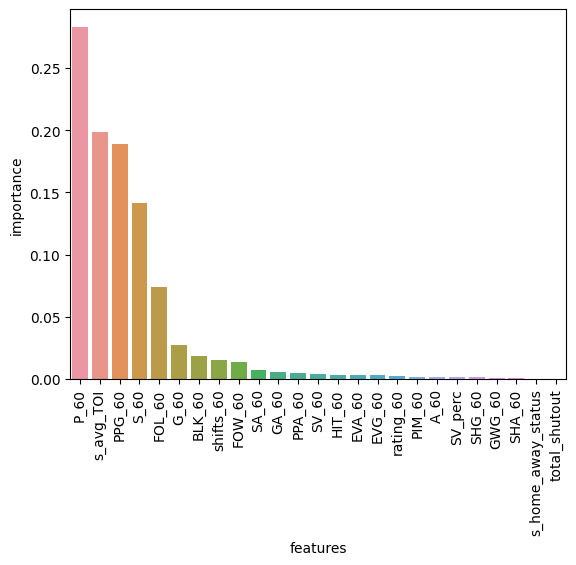

In [29]:
# Look at feature importances
importances = pd.DataFrame({'features':rf.feature_names_in_, 'importance':rf.feature_importances_})
ax = sns.barplot(importances.sort_values('importance', ascending=False), x = 'features', y = 'importance')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

It looks like the following variables are more important than the rest: ['P_60', 's_avg_TOI', 'PPG_60', 'S_60', 'FOL_60', 'G_60', 'BLK_60', 'shifts_60', 'FOW_60', 'SA_60', 'GA_60']
* This for the most part lines up well with the EDA section using mean difference between 0/1. 
* FOW/FOL might not need to be separate. Might just matter that they are a C.

### Try training RF using only the above subset
Based on CV, the best parameters using these variables is the following: 
* x

In [30]:
x_train_subset = x_train[['P_60', 's_avg_TOI', 'PPG_60', 'S_60', 'FOL_60', 'G_60', 'BLK_60', 'shifts_60', 'FOW_60', 'SA_60', 'GA_60']]
x_test_subset = x_test[['P_60', 's_avg_TOI', 'PPG_60', 'S_60', 'FOL_60', 'G_60', 'BLK_60', 'shifts_60', 'FOW_60', 'SA_60', 'GA_60']]

In [31]:
# Train RF using parameters from model exploration notebook
rf = RandomForestRegressor(max_depth=5, n_estimators=50)
rf.fit(x_train_subset, y_train)

RandomForestRegressor(max_depth=5, n_estimators=50)

[Text(0, 0, 'P_60'),
 Text(1, 0, 'PPG_60'),
 Text(2, 0, 's_avg_TOI'),
 Text(3, 0, 'S_60'),
 Text(4, 0, 'FOL_60'),
 Text(5, 0, 'G_60'),
 Text(6, 0, 'BLK_60'),
 Text(7, 0, 'FOW_60'),
 Text(8, 0, 'shifts_60'),
 Text(9, 0, 'SA_60'),
 Text(10, 0, 'GA_60')]

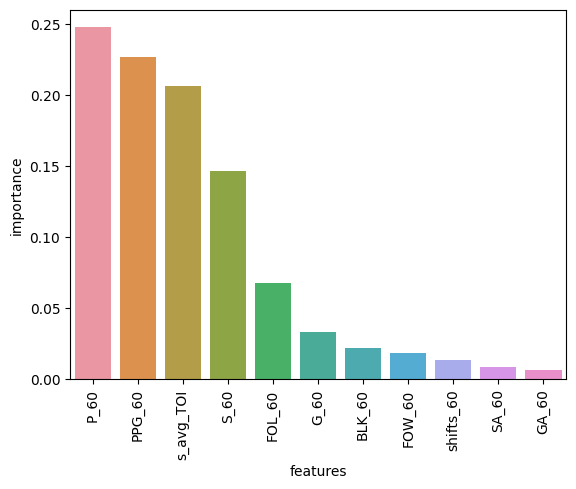

In [32]:
importances = pd.DataFrame({'features':rf.feature_names_in_, 'importance':rf.feature_importances_})
ax = sns.barplot(importances.sort_values('importance', ascending=False), x = 'features', y = 'importance')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [33]:
# Make predictions about each player's goals per game
preds = pd.DataFrame({'preds':rf.predict(x_test_subset)}, index = test.index)

In [34]:
# For anyone that we did not make a prediction for, fill with the average goals per game
player_predictions = pd.merge(feature_set_for_preds, preds, left_index=True, right_index=True, how = 'left').fillna({'preds':avg_G_per_game})
player_predictions.head()

,s_player_id,s_name,s_team,date,s_result,G,preds
78430,/a/abruzni01,Nicholas Abruzzese,TOR,2023-04-02,L,0,0.170124
78431,/a/abruzni01,Nicholas Abruzzese,TOR,2023-04-04,W,0,0.170124
78484,/a/acciano01,Noel Acciari,STL,2023-02-14,W,0,0.210189
78485,/a/acciano01,Noel Acciari,STL,2023-02-16,W,0,0.210620
78486,/a/acciano01,Noel Acciari,TOR,2023-02-18,W,0,0.213626


In [35]:
# Find the expected number of goals for each team for each day
# Start by looking at the number of players we have for each team for each day
num_players_per_game = player_predictions.groupby(['s_team', 'date'])['s_player_id'].count().reset_index().rename(columns={'s_player_id':'n_players'})
#display(num_players_per_game.head())

# Sum player predictions to get the expected goals for each team per each game
team_xGoals = player_predictions.groupby(['s_team', 'date'])['preds'].sum().reset_index().rename(columns={'preds':'xG'})
team_xGoals = pd.merge(team_xGoals, num_players_per_game, how = 'left', on = ['s_team', 'date'])
team_xGoals.rename(columns={'s_team':'team'}, inplace=True)

# If any team had less than 18 skaters, add the correct multiple of average goals per game to get them back to 18
# This assumes a team ALWAYS has 18 skaters. Does a team ever play with less than 18 skaters?
team_xGoals['xG'] = (team_xGoals['xG'] + avg_G_per_game * (18 - team_xGoals['n_players']))
team_xGoals.drop(columns='n_players', inplace = True)

team_xGoals.head()


,team,date,xG
0,ANA,2023-02-15,2.938656
1,ANA,2023-02-17,2.833243
2,ANA,2023-02-20,2.988559
3,ANA,2023-02-21,2.972012
4,ANA,2023-02-23,2.903525


## Export predictions

In [36]:
team_xGoals.to_csv('../data/evaluation_predictions/rf_test_021323.csv', header=True, index=False)